Import packages

In [261]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

Data import from excel

In [262]:
df = pd.read_excel("stock_data.xlsx", sheet_name="data")

In [264]:
df.head()

,RIC,30.09.2023,29.09.2023,28.09.2023,27.09.2023,26.09.2023,25.09.2023,24.09.2023,23.09.2023,22.09.2023,...,10.01.2013,09.01.2013,08.01.2013,07.01.2013,06.01.2013,05.01.2013,04.01.2013,03.01.2013,02.01.2013,01.01.2013
0,.DJI,134030.00,134030.00,134665.36,134201.08,134475.52,136027.52,135855.36,135855.36,135855.36,...,53884.88,53562.04,53315.40,53537.16,53740.84,53740.84,53740.84,53565.44,53650.20,NaN
1,.STOXX,1800.88,1800.88,1794.00,1787.64,1790.80,1801.76,1813.04,1813.04,1813.04,...,1149.76,1152.88,1145.00,1146.52,1151.32,1151.32,1151.32,1147.32,1141.32,NaN
2,.FTSE,30432.32,30432.32,30407.40,30372.88,30502.88,30495.96,30735.64,30735.64,30735.64,...,24406.04,24394.60,24214.52,24258.32,24359.36,24359.36,24359.36,24189.36,24109.48,NaN
3,.GDAXI,61546.32,61546.32,61294.00,60869.80,61023.48,61621.96,62229.16,62229.16,62229.16,...,30833.88,30881.88,30783.32,30930.64,31105.48,31105.48,31105.48,31025.76,31115.12,NaN
4,.HSI,71238.64,71238.64,69492.12,70447.48,69867.60,70917.16,72229.80,72229.80,72229.80,...,93417.24,92873.88,92444.76,93319.00,93324.36,93324.36,93324.36,93594.40,93247.92,NaN


In [265]:
df.shape

(5, 3926)

Data modelling

In [266]:
# Unpivot columns except 'RIC' column
df = pd.melt(df, id_vars='RIC', var_name='Trade Date', value_name='Universal Close Price')

# Convert 'Trade Date' to date format
df['Trade Date'] = pd.to_datetime(df['Trade Date'], format='%d.%m.%Y')

# Create pivot table
df = df.pivot(index='Trade Date', columns='RIC', values='Universal Close Price')

In [267]:
# Delete rows in case it is weekend
df = df[df.index.weekday < 5]

Get Nikkei 225 and S&P 500 data from yahoo finance

In [269]:
# Set start and and date
start_date = df.index.min()
end_date = df.index.max()

In [270]:
# Download yahoo finance data
tickers_list = ['^N225', '^GSPC']
yahoo_object = yf.Tickers(tickers_list)
yahoo_prices = yahoo_object.history(start=start_date, end=end_date, interval='1d').Close

[*********************100%***********************]  2 of 2 completed


In [271]:
# Round stock prices
yahoo_prices = yahoo_prices.round(decimals=2)

# Rename columns
map_tickers = {'^GSPC': '.INX',
               '^N225': '.N225'}
yahoo_prices = yahoo_prices.rename(columns=map_tickers)

In [272]:
yahoo_prices.head(5)

,.INX,.N225
Date,,
2013-01-02,1462.42,NaN
2013-01-03,1459.37,NaN
2013-01-04,1466.47,10688.11
2013-01-07,1461.89,10599.01
2013-01-08,1457.15,10508.06


Merge dataframes

In [273]:
# Join yahoo finance data to original dataframe by index values
df = df.join(yahoo_prices)

In [274]:
df.head(5)

,.DJI,.FTSE,.GDAXI,.HSI,.STOXX,.INX,.N225
Trade Date,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,53650.20,24109.48,31115.12,93247.92,1141.32,1462.42,NaN
2013-01-03,53565.44,24189.36,31025.76,93594.40,1147.32,1459.37,NaN
2013-01-04,53740.84,24359.36,31105.48,93324.36,1151.32,1466.47,10688.11
2013-01-07,53537.16,24258.32,30930.64,93319.00,1146.52,1461.89,10599.01


Analyse missing values

In [275]:
# Count missing values for each column
df.isna().sum(axis=0)

.DJI        1
.FTSE       1
.GDAXI      1
.HSI        1
.STOXX      1
.INX      100
.N225     178
dtype: int64

<Axes: xlabel='Trade Date'>

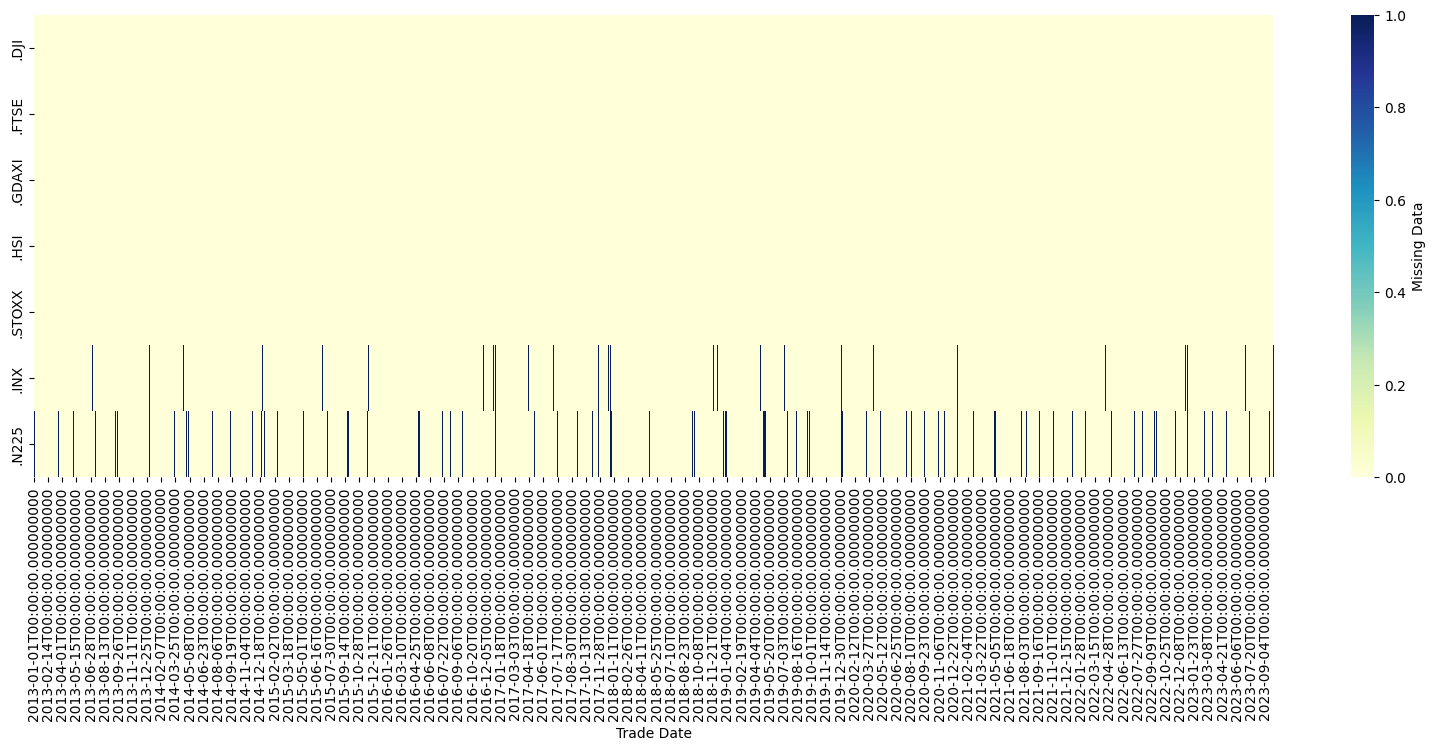

In [276]:
# Visualize missing values
plt.figure(figsize=(20,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [277]:
# Fill missing values with previous available data. When starting values are missing, take next available
df = df.ffill().bfill()

In [278]:
# Any rows with missing data?
df[df.isna().any(axis=1)]

,.DJI,.FTSE,.GDAXI,.HSI,.STOXX,.INX,.N225
Trade Date,,,,,,,


Data modelling 2

In [279]:
# Reorder columns
df = df[['.DJI', '.STOXX', '.FTSE', '.GDAXI', '.N225', '.HSI','.INX']]

# Index values into columns
df = df.reset_index()

# Unpivot columns
df = pd.melt(df, id_vars='Trade Date', var_name='RIC', value_name='Universal Close Price')

In [280]:
# Functions

def dot_separated_date(date):
    """
    Formats a given date object into a dot-separated string.

    Args:
        date (datetime.date): The date to be formatted.

    Returns:
        str: A string representing the date in the format 'dd.mm.yyyy'.
    """
    date_dot_sep = date.strftime('%d.%m.%Y')
    return date_dot_sep

def format_float_to_desired(value):
    """
    Formats a floating-point number as a string with comma and dot swapped.

    Args:
        value (float): The floating-point number to be formatted.

    Returns:
        str: A string representation of the number with ',' and '.' swapped, formatted as 'X,XXX.XX'.
    """
    formatted_value = '{:,.2f}'.format(value).replace(',', 'X').replace('.', ',').replace('X', '.')
    return formatted_value

In [281]:
df['Trade Date'] = df['Trade Date'].apply(dot_separated_date)
df['Universal Close Price'] = df['Universal Close Price'].apply(format_float_to_desired)

In [282]:
df.head(5)

,Trade Date,RIC,Universal Close Price
0,01.01.2013,.DJI,"53.650,20"
1,02.01.2013,.DJI,"53.650,20"
2,03.01.2013,.DJI,"53.565,44"
3,04.01.2013,.DJI,"53.740,84"
4,07.01.2013,.DJI,"53.537,16"


Create file per date

In [230]:
date_sequence = df['Trade Date'].unique()

In [231]:
def get_filename(date):
    """
    Generates a filename based on a dot-separated date.

    Args:
        date (str): A string representing a date in the format 'dd.mm.yyyy'.

    Returns:
        str: A formatted filename in the format 'yyyymmdd_stock_index'.

    Example:
        If date is '25.10.2023', the function will return '20231025_stock_index'.
    """
    date_list = date.split('.')[::-1]
    prefix_date = ''.join(date_list)
    filename = f"{prefix_date}_stock_index"
    return filename


In [232]:
# for loop to create an stock index prices file for each date
for date_item in date_sequence:
    # Get date
    df_subset = df[df['Trade Date'] == date_item]
    # Get file name & set path
    file_name = get_filename(date_item)
    file_name_path = f"files_created/{file_name}.csv"
    # Create a file
    df_subset.to_csv(file_name_path, index=None, sep=',')